In [ ]:
# =========================
# 0) Setup & Dataset Download from Kaggle
# =========================
!pip install kagglehub --quiet

import os, math, itertools, numpy as np, matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Download dataset from KaggleHub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)


DATA_ROOT = path
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]

IMG_SIZE = 224
BATCH_SIZE = 32
VAL_SPLIT = 0.15
SEED = 1337
EPOCHS = 15

assert os.path.isdir(os.path.join(DATA_ROOT, "Training")), "Training folder not found"
assert os.path.isdir(os.path.join(DATA_ROOT, "Testing")), "Testing folder not found"
print("Dataset found ✅")


Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Dataset found ✅


Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts : {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}
Class weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


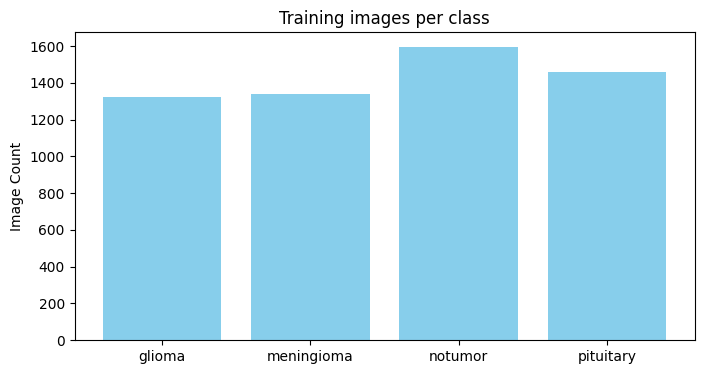

In [ ]:
# =========================
# 1) Count images & compute class weights
# =========================
def count_per_class(split_dir):
    counts = {}
    for c in CLASS_NAMES:
        cdir = os.path.join(split_dir, c)
        counts[c] = len([f for f in os.listdir(cdir) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff"))])
    return counts

train_counts = count_per_class(os.path.join(DATA_ROOT, "Training"))
test_counts  = count_per_class(os.path.join(DATA_ROOT, "Testing"))

print("Train counts:", train_counts)
print("Test counts :", test_counts)

total = sum(train_counts.values())
class_weights = {i: total / (len(CLASS_NAMES) * train_counts[c]) for i, c in enumerate(CLASS_NAMES)}
print("Class weights:", class_weights)

plt.figure(figsize=(8,4))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title("Training images per class")
plt.ylabel("Image Count")
plt.show()


In [ ]:
# =========================
# 2) tf.data pipeline with aspect ratio preservation
# =========================
def make_ds(split_path, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        split_path,
        labels="inferred",
        label_mode="int",
        class_names=CLASS_NAMES,
        color_mode="rgb",
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=shuffle,
        seed=SEED,
        batch_size=BATCH_SIZE
    )
    def _preprocess(x, y):
        x = tf.image.resize_with_pad(x, IMG_SIZE, IMG_SIZE)
        x = tf.cast(x, tf.float32) / 255.0
        return x, y
    return ds.map(_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

full_train = make_ds(os.path.join(DATA_ROOT, "Training"), shuffle=True)

cardinality = tf.data.experimental.cardinality(full_train).numpy()
val_batches = int(math.floor(cardinality * VAL_SPLIT))
train_batches = cardinality - val_batches
print(f"Train batches: {train_batches}, Val batches: {val_batches}")

val_ds   = full_train.take(val_batches)
train_ds = full_train.skip(val_batches)
test_ds  = make_ds(os.path.join(DATA_ROOT, "Testing"), shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1024, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 5712 files belonging to 4 classes.
Train batches: 153, Val batches: 26
Found 1311 files belonging to 4 classes.


In [ ]:
# =========================
# 3) Data augmentation
# =========================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")


In [ ]:
# =========================
# 4) Custom CNN Model
# =========================
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = conv_block(x, 32)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.15)(x)

x = conv_block(x, 64)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.2)(x)

x = conv_block(x, 128)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = conv_block(x, 256)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.35)(x)

outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)

model = keras.Model(inputs, outputs, name="brain_tumor_cnn")
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


Model: "brain_tumor_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,307,748 (4.99 MB)

 Trainable params: 1,305,828 (4.98 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5777 - loss: 0.9980
Epoch 1: val_accuracy improved from -inf to 0.37620, saving model to /content/best_brain_tumor_cnn.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 89s 339ms/step - accuracy: 0.5782 - loss: 0.9971 - val_accuracy: 0.3762 - val_loss: 1.9167 - learning_rate: 0.0010
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7180 - loss: 0.7265
Epoch 2: val_accuracy did not improve from 0.37620
153/153 ━━━━━━━━━━━━━━━━━━━━ 107s 318ms/step - accuracy: 0.7181 - loss: 0.7263 - val_accuracy: 0.2993 - val_loss: 1.6036 - learning_rate: 0.0010
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7698 - loss: 0.6360
Epoch 3: val_accuracy improved from 0.37620 to 0.43029, saving model to /content/best_brain_tumor_cnn.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 318ms/step - accuracy: 0.7698 - loss: 0.6360 - val_accuracy: 0.4303 - val_loss: 1.9114 - learning_rate: 0.0010
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━

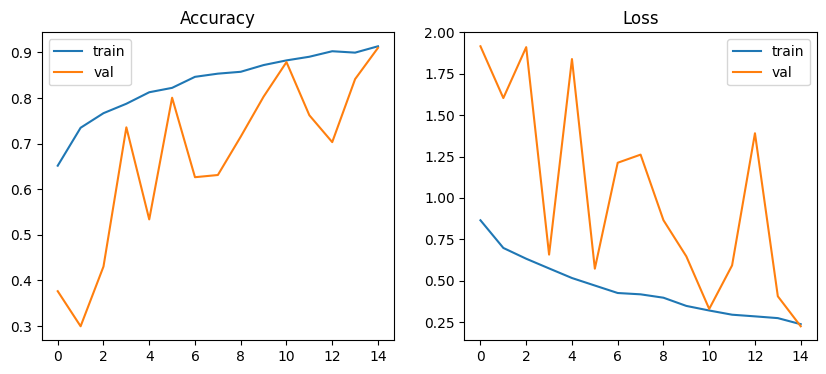

In [ ]:
# =========================
# 5) Train
# =========================
ckpt_path = "/content/best_brain_tumor_cnn.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()
plt.show()


Test accuracy: 0.9001 | Test loss: 0.2805

Classification report:
              precision    recall  f1-score   support

      glioma     0.9345    0.9033    0.9186       300
  meningioma     0.8640    0.7059    0.7770       306
     notumor     0.9182    0.9704    0.9436       405
   pituitary     0.8746    1.0000    0.9331       300

    accuracy                         0.9001      1311
   macro avg     0.8978    0.8949    0.8931      1311
weighted avg     0.8993    0.9001    0.8966      1311



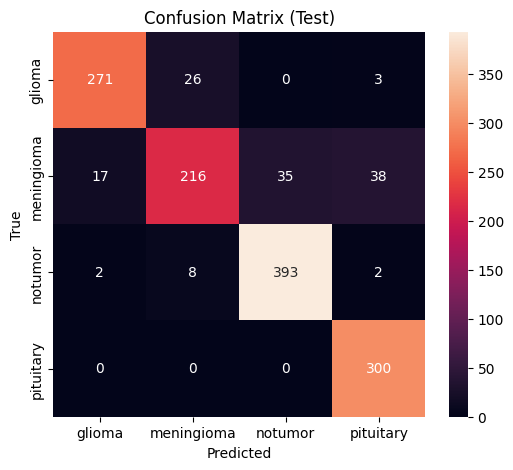

In [ ]:
# =========================
# 6) Evaluate on Test set
# =========================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

y_true = []
y_pred = []
for batch_x, batch_y in test_ds:
    preds = model.predict(batch_x, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(batch_y.numpy().tolist())

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# =========================
# 7) Save the final Custom CNN model
# =========================

# Define the path and filename for the saved model
final_cnn_model_path = "/content/final_brain_tumor_cnn.keras"

# Save the model
model.save(final_cnn_model_path)

print(f"Custom CNN model saved to {final_cnn_model_path}")

Custom CNN model saved to /content/final_brain_tumor_cnn.keras


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Phase 1: Training classification head...
Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.2440 - loss: 0.2074 - val_accuracy: 0.2849 - val_loss: 0.1964
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.2723 - loss: 0.2002 - val_accuracy: 0.3305 - val_loss: 0.1940
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.2747 - loss: 0.2009 - val_accuracy: 0.2380 - val_loss: 0.1959
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.2615 - loss: 0.2014 - val_accuracy: 0.2849 - val_loss: 0.1923
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.2665 - loss: 0.1984 - val_accuracy: 0.2356 - val_loss: 0.1987
Phase 2: Fine-tuning deeper layers...
Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3161 - loss: 0.2016
Epoch 1: val_accuracy improved from -inf to 0.25841, saving model to /content/best_effnet.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/s

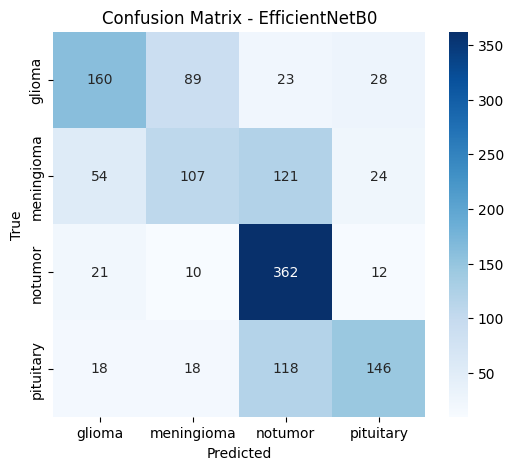


📊 Model Comparison:
Custom CNN Test Accuracy: 0.9001
EfficientNetB0 Test Accuracy: 0.5912
✅ Custom CNN outperformed EfficientNetB0.


In [ ]:
# =========================
# 8) EfficientNetB0 Training
# =========================

from tensorflow.keras import backend as K


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(CLASS_NAMES))
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        loss = tf.reduce_sum(weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# ---- Preprocessing for EfficientNet ----
def preprocess_effnet(x, y):

    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x, y

train_ds_eff = train_ds.map(preprocess_effnet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_eff   = val_ds.map(preprocess_effnet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_eff  = test_ds.map(preprocess_effnet, num_parallel_calls=tf.data.AUTOTUNE)


base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)
base_model.trainable = False  # Phase 1: freeze

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)

effnet_model = keras.Model(inputs, outputs, name="EfficientNetB0_transfer")

# =========================
# Phase 1: Train classification head
# =========================
effnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)

print("Phase 1: Training classification head...")
effnet_model.fit(
    train_ds_eff,
    validation_data=val_ds_eff,
    epochs=5,
    class_weight=class_weights,
    verbose=1
)

# =========================
# Phase 2: Fine-tune deeper layers
# =========================
print("Phase 2: Fine-tuning deeper layers...")


base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

effnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=focal_loss(gamma=2., alpha=0.25),  # same focal loss
    metrics=["accuracy"]
)

eff_ckpt_path = "/content/best_effnet.keras"
eff_callbacks = [
    keras.callbacks.ModelCheckpoint(eff_ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

history_eff = effnet_model.fit(
    train_ds_eff,
    validation_data=val_ds_eff,
    epochs=20,   # allow more fine-tuning
    class_weight=class_weights,
    callbacks=eff_callbacks,
    verbose=1
)

# =========================
# Evaluate on Test set
# =========================
eff_test_loss, eff_test_acc = effnet_model.evaluate(test_ds_eff, verbose=0)
print(f"EfficientNetB0 Test accuracy: {eff_test_acc:.4f} | Test loss: {eff_test_loss:.4f}")


y_true_eff, y_pred_eff = [], []
for batch_x, batch_y in test_ds_eff:
    preds = effnet_model.predict(batch_x, verbose=0)
    y_pred_eff.extend(np.argmax(preds, axis=1))
    y_true_eff.extend(batch_y.numpy().tolist())

print("\nEfficientNetB0 Classification report:")
print(classification_report(y_true_eff, y_pred_eff, target_names=CLASS_NAMES, digits=4))

# Confusion Matrix
cm_eff = confusion_matrix(y_true_eff, y_pred_eff)
plt.figure(figsize=(6,5))
sns.heatmap(cm_eff, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.title("Confusion Matrix - EfficientNetB0")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =========================
# Model comparison summary
# =========================
print("\n📊 Model Comparison:")
print(f"Custom CNN Test Accuracy: {test_acc:.4f}")
print(f"EfficientNetB0 Test Accuracy: {eff_test_acc:.4f}")

if eff_test_acc > test_acc:
    print("✅ EfficientNetB0 outperformed the Custom CNN.")
elif eff_test_acc < test_acc:
    print("✅ Custom CNN outperformed EfficientNetB0.")
else:
    print("🤝 Both models achieved the same accuracy.")


In [ ]:
# =========================
# 9) Save the final EfficientNetB0 model
# =========================

# Define the path and filename for the saved model
final_effnet_model_path = "/content/final_efficientnet_model.keras"

# Save the model
effnet_model.save(final_effnet_model_path)

print(f"EfficientNetB0 model saved to {final_effnet_model_path}")

EfficientNetB0 model saved to /content/final_efficientnet_model.keras
